In [1]:
import geopandas as gpd 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
from datetime import timedelta
 


For Italian data use these cells

In [ ]:
# Replace 'path/to/your/csv/file.csv' with the actual path to your CSV file
data = pd.read_csv('/home/sallyfons/MLEE/italy_heartquakes_1985_2022.csv')

data['datetime'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
data['date_num'] = data['datetime'].apply(lambda x: datetime.timestamp(x))

# Print the data
print(data)
# Checking for missing values
print(data.isnull().sum())

In [ ]:
# Define the extent of the specific area
min_latitude = 40.0
max_latitude = 44.0
min_longitude = 10.0
max_longitude = 15.0

# Filter the 'data' DataFrame to include only the points within the specific area
data = data[(data['latitude'] >= min_latitude) & (data['latitude'] <= max_latitude) & (data['longitude'] >= min_longitude) & (data['longitude'] <= max_longitude)]

# Print the points inside the area
print(data)


For Turkey earthquakes use this cell

In [2]:
# Replace 'path/to/your/csv/file.csv' with the actual path to your CSV file
data = pd.read_csv('/home/sallyfons/MLEE/turkey_earthquakes(1915-2021).csv')

# Translate the header names from Turkish to English
data = data.rename(columns={'Deprem Kodu': 'Earthquake Code', 'Olus tarihi': 'date', 'Olus zamani': 'time', 'Enlem': 'latitude', 'Boylam': 'longitude', 'Derinlik': 'depth', 'Tip': 'Type (eq/ex)', 'Yer': 'Location'})


# Convert the date and time columns to datetime format
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'], format='%d/%m/%Y %H:%M:%S')

# Sort the data by date
data = data.sort_values('datetime', ascending=True)
# Filter out rows with missing or invalid dates

data = data[data['datetime'].notnull()]

# Convert the datetime column to numeric format
data['date_num'] = data['datetime'].apply(lambda x: datetime.timestamp(x))



print(f' Numeric dates that are NaN: {data["date_num"].isnull().sum()}')
print(f' Latitude that are NaN: {data["latitude"].isnull().sum()}')
print(f' Moment Magnitude that are NaN or 0: {(data["Mw"].isnull() | (data["Mw"] == 0)).sum()}')
print(f' Local Magnitude that are NaN or 0: {(data["ML"].isnull() | (data["ML"] == 0)).sum()}')
count = ((data['Mw'].isnull() | (data['Mw'] == 0)) & (data['ML'].isnull() | (data['ML'] == 0))).sum()
print(f'Number of rows where both "Mw" and "ML" are either 0 or NaN: {count}')
print(f' Depths that are NaN: {data["depth"].isnull().sum()}')

#Due to high number of NaN in Mw, ML will be used. Also the same one as in the Italy Earthquake Prediction model
#not the case anymore, xM will be used instead of ML
data = data.rename(columns={'xM': 'magnitude'})
# Drop rows where the values of ML are NaN
data = data.dropna(subset=['magnitude'], how='any')

# Drop rows where the values of ML are 0
data = data[data['magnitude'] != 0]

# Print the data
print(data)
print(data.columns)
print(f' Moment Magnitude that are NaN or 0: {(data["Mw"].isnull() | (data["Mw"] == 0)).sum()}')

print(data['Type (eq/ex)'].unique())


 Numeric dates that are NaN: 0
 Latitude that are NaN: 0
 Moment Magnitude that are NaN or 0: 12894
 Local Magnitude that are NaN or 0: 8491
Number of rows where both "Mw" and "ML" are either 0 or NaN: 8440
 Depths that are NaN: 0
          No  Earthquake Code        date      time  latitude  longitude  \
6087   17370     1.915020e+13  14/02/1915  08:20:01   38.8000    42.5000   
9099   17369     1.915020e+13  28/02/1915  12:47:02   37.7000    43.1000   
4392   17368     1.915040e+13  01/04/1915  05:41:05   40.5000    44.5000   
3745   17367     1.915050e+13  19/05/1915  04:48:02   37.6200    39.4700   
5462   17366     1.915090e+13  23/09/1915  07:20:01   40.0000    43.0000   
...      ...              ...         ...       ...       ...        ...   
14315      5     2.020120e+13  27/12/2020  20:08:37   38.4172    39.1482   
9683       4     2.020120e+13  30/12/2020  13:40:12   37.7960    26.4165   
13291      3     2.020120e+13  30/12/2020  18:45:13   36.4918    28.7092   
694      

Explore the data

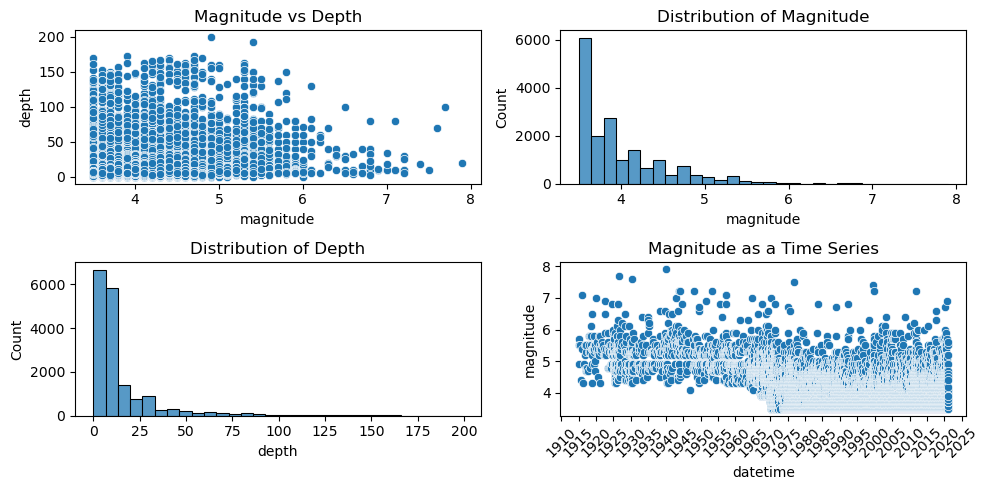

In [4]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

# Scatter plot of magnitude vs depth
sns.scatterplot(x='magnitude', y='depth', data=data, ax=axes[0, 0])
axes[0, 0].set_title('Magnitude vs Depth')

# Distribution plot of magnitude
sns.histplot(data['magnitude'], bins=30, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Magnitude')

# Distribution plot of depth
sns.histplot(data['depth'], bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Depth')

# Scatter plot of magnitude as a time series
sns.scatterplot(x='datetime', y='magnitude', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Magnitude as a Time Series')

# Set the locator for the x-axis to show every couple of years
axes[1, 1].xaxis.set_major_locator(mdates.YearLocator(5))

# Format the date on the x-axis
axes[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

Plotting the Gutenber-Richter Relationship for the Region/Dataset

a value: 6.893385334157804
b value: -0.8765885775414504
coefficients: [-0.87658858  6.89338533]


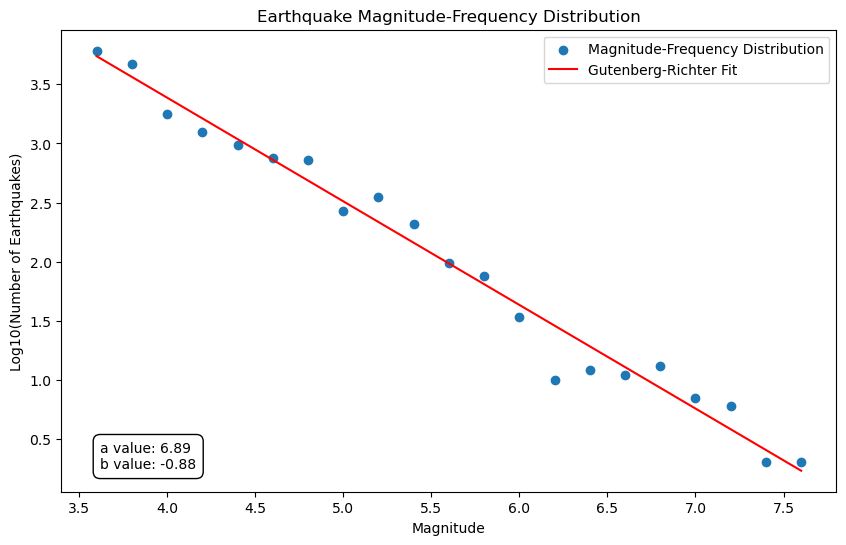

In [5]:
#Count number of earthquakes for each magnitude & extract vaues from midpoint of bins
mag_counts, mag_bins = np.histogram(data['magnitude'], bins=np.arange(data['magnitude'].min(), data['magnitude'].max(), 0.2))
mag_values = (mag_bins[:-1] + mag_bins[1:]) / 2

# Perform linear regression on the log-transformed data
log_mag_counts = np.log10(np.where(mag_counts > 0, mag_counts, 1))

# Fit a linear function to the log-transformed data
coeff = np.polyfit(mag_values, log_mag_counts, 1)
b, a = coeff

# Display the results
print(f"a value: {a}")
print(f"b value: {b}")
print(f"coefficients: {coeff}")

# Plot the earthquake magnitude-frequency distribution
plt.figure(figsize=(10, 6))
plt.scatter(mag_values, log_mag_counts, label='Magnitude-Frequency Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Log10(Number of Earthquakes)')
plt.title('Earthquake Magnitude-Frequency Distribution')

# Plot the fitted curve
plt.plot(mag_values, a + b * mag_values, color='red', label='Gutenberg-Richter Fit')

# Display the legend
plt.legend()

# Add a box with the a and b values
plt.text(0.05, 0.05, f"a value: {a:.2f}\nb value: {b:.2f}", transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.show()

Plotting the earthquakes

In [ ]:
# Load the country borders shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a GeoDataFrame from the latitude and longitude columns
geometry = gpd.points_from_xy(data['longitude'], data['latitude'])
gdf_eq = gpd.GeoDataFrame(data, geometry=geometry)

# Create a figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Set the x-axis and y-axis limits based on the data
ax[0].set_xlim(data['longitude'].min() - 1, data['longitude'].max() + 1)
ax[0].set_ylim(data['latitude'].min() - 1, data['latitude'].max() + 1)
ax[1].set_xlim(data['longitude'].min() - 1, data['longitude'].max() + 1)
ax[1].set_ylim(data['latitude'].min() - 1, data['latitude'].max() + 1)
# Plot the country borders as a background map
world.plot(ax=ax[0], color='white', edgecolor='black')
world.plot(ax=ax[1], color='white', edgecolor='black')
# Set the aspect ratio of the plot
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
# Plot the data points

# Filter the data to include only magnitudes higher than 5.5
filtered_data = gdf_eq[gdf_eq['magnitude'] > 5.5]

# Plot the filtered data points
filtered_data.plot(ax=ax[0], column='depth', cmap='coolwarm', markersize=10, legend=True)
filtered_data.plot(ax=ax[1], column='magnitude', cmap='coolwarm', markersize=10, legend=True)
#gdf_eq.plot(ax=ax[0], column='depth', cmap='coolwarm', markersize= 10 , legend=True)
#gdf_eq.plot(ax=ax[1], column='magnitude', cmap='coolwarm', markersize=10, legend=True)

# Set the plot title and axis labels
ax[0].set_title('Earthquake Depths')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[1].set_title('Earthquake Magnitudes')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

# Show the colorbar
plt.colorbar(ax= ax[0], label='Depth')
plt.colorbar(ax=ax[1], label='Magnitude')

# Show the plot
plt.show()


/tmp/ipykernel_87162/4221665165.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/tmp/ipykernel_87162/4221665165.py:23: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  small.plot(ax=ax, marker = 'o', color = 'peachpuff', column='magnitude', markersize=10, zorder = 2, label = 'Magnitude < 5.5')
/tmp/ipykernel_87162/4221665165.py:24: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  medium.plot(ax=ax, marker = 'o', color = 'orange', column='magnitude', markersize=20, zorder = 3, label = 'Magnitude 5.5 - 6.0')
/tmp/ipykernel_87162/4221665165.py:25: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  large.plot(ax=ax, marker = 'o', color = 'darkred', column='magnitude', markersize=30, 

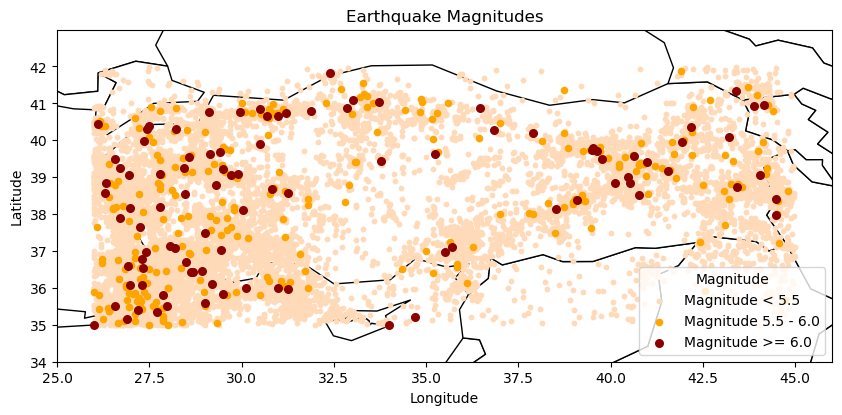

In [7]:
# Load the country borders shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a GeoDataFrame from the latitude and longitude columns
geometry = gpd.points_from_xy(data['longitude'], data['latitude'])
gdf_eq = gpd.GeoDataFrame(data, geometry=geometry)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

#set the x-axis and y-axis limits based on the data
ax.set_xlim(data['longitude'].min() - 1, data['longitude'].max() + 1)
ax.set_ylim(data['latitude'].min() - 1, data['latitude'].max() + 1)
# Plot the country borders as a background map
world.plot(ax=ax, color='white', edgecolor='black')

# Filter the data to include only magnitudes higher than 5.5
small = gdf_eq[gdf_eq['magnitude'] < 5.5]
medium = gdf_eq[(gdf_eq['magnitude'] >= 5.5) & (gdf_eq['magnitude'] < 6.0) ]
large = gdf_eq[gdf_eq['magnitude'] >= 6.0]

# Plot the earthquake magnitudes
small.plot(ax=ax, marker = 'o', color = 'peachpuff', column='magnitude', markersize=10, zorder = 2, label = 'Magnitude < 5.5')
medium.plot(ax=ax, marker = 'o', color = 'orange', column='magnitude', markersize=20, zorder = 3, label = 'Magnitude 5.5 - 6.0')
large.plot(ax=ax, marker = 'o', color = 'darkred', column='magnitude', markersize=30, zorder = 4, label = 'Magnitude >= 6.0')

# Set the plot title and axis labels
ax.set_title('Earthquake Magnitudes')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#Show the legend
ax.legend(loc='lower right', title='Magnitude')

# Show the plot
plt.show()


Introduce seismic parameters from date/magnitude data

In [3]:
#Cut-off Magnitude
cutoff_mag = 5.5
min_mag = 3.5

# Add a new column 'HighMagnitude' based on the magnitude
data['HighMagnitude'] = data['magnitude'].apply(lambda x: 1 if x >= cutoff_mag else 0)

# Print the updated DataFrame
print(data['HighMagnitude'].value_counts())

#Define a function to check if there is a high magnitude earthquake in the next 7 days
def check_next_week_high_magnitude(row):
    next_week = row['datetime'] + timedelta(days=7)
    next_week_data = data[(data['datetime'] > row['datetime']) & (data['datetime'] <= next_week)]
    return 1 if any(next_week_data['magnitude'] >= cutoff_mag) else 0


# Define a function to compute the maximum magnitude in the last 7 days
def compute_max_magnitude(row):
    last_week = row['datetime'] - timedelta(days=7)
    last_week_data = data[(data['datetime'] > last_week) & (data['datetime'] <= row['datetime'])]
    return last_week_data['magnitude'].max()



# Apply the function to create the 'NextWeekHighMagnitude' column
data['NextWeekHighMagnitude'] = data.apply(check_next_week_high_magnitude, axis=1)

#Apply the function to create the Max Magnitude column 'x6
data['x6'] = data.apply(compute_max_magnitude, axis=1)
# Add a new column 'TimeElapsed' that calculates the time elapsed between each event
data['TimeElapsed'] = data['date_num'].diff()
data['TimeElapsed'] = data['TimeElapsed'].fillna(0)


# Print the updated DataFrame
print(data['NextWeekHighMagnitude'].value_counts())
print(data[10100:10107])
print(data.columns)




HighMagnitude
0    17000
1      370
Name: count, dtype: int64
NextWeekHighMagnitude
0    15888
1     1482
Name: count, dtype: int64
         No  Earthquake Code        date      time  latitude  longitude  \
3638   7270     2.004040e+13  01/04/2004  04:39:18     39.85      40.71   
6209   7269     2.004040e+13  01/04/2004  08:31:13     39.94      40.78   
6261   7268     2.004040e+13  01/04/2004  08:35:20     39.95      40.80   
12382  7267     2.004040e+13  01/04/2004  17:31:50     39.91      40.79   
14408  7266     2.004040e+13  01/04/2004  20:15:28     39.92      40.77   
10099  7265     2.004040e+13  02/04/2004  14:12:35     35.23      27.78   
12624  7264     2.004040e+13  02/04/2004  17:52:16     39.89      40.75   

       depth  magnitude  MD   ML  ...  Ms  Mb  Type (eq/ex)  \
3638    10.0        3.5   4  0.0  ...   0   0            Ke   
6209    10.0        3.8   4  0.0  ...   0   0            Ke   
6261    10.0        4.7   4  4.6  ...   5   0            Ke   
12382   10.0   

In [4]:
#Adding more parameters

data['local_b_value'] = 0.4343 / (data['magnitude'].rolling(window=50, min_periods=1).mean() - min_mag)
data['meanM'] = data['magnitude'].rolling(window=50, min_periods=1).mean()
data['x7'] = 10 ** (-3 * data['local_b_value'])
data['E'] = 10 ** (1.5 * data['magnitude'] + 11.8)
data['E'] = data['E'].apply(np.sqrt)

# Print the head of the updated DataFrame
print(data.head())
# Calculate T
# Calculate T
data['T'] = data['date_num'].diff().rolling(window=50, min_periods=1).sum()
#Calcualte dE/dt
data['dE/dt'] = data['E'].rolling(window=50, min_periods=1).sum() / data['T']
#Calculate sum of E
data['sum_of_E'] = data['E'].cumsum()


# Print the head of the updated DataFrame
print(data.head())
print(data.columns)
#print(data[['magnitude', 'date', 'local_b_value', 'x6', 'x7']][9580:9589])
#print(data[['magnitude', 'date', 'local_b_value', 'x6', 'x7']][10101:10106])
#print(data[data['magnitude'] > 5][['date', 'local_b_value', 'x6', 'x7']].head(10))



         No  Earthquake Code        date      time  latitude  longitude  \
6087  17370     1.915020e+13  14/02/1915  08:20:01     38.80      42.50   
9099  17369     1.915020e+13  28/02/1915  12:47:02     37.70      43.10   
4392  17368     1.915040e+13  01/04/1915  05:41:05     40.50      44.50   
3745  17367     1.915050e+13  19/05/1915  04:48:02     37.62      39.47   
5462  17366     1.915090e+13  23/09/1915  07:20:01     40.00      43.00   

      depth  magnitude  MD   ML  ...            datetime      date_num  \
6087   30.0        5.7   5  5.4  ... 1915-02-14 08:20:01 -1.731862e+09   
9099   30.0        5.5   5  5.2  ... 1915-02-28 12:47:02 -1.730636e+09   
4392   35.0        4.9   5  4.8  ... 1915-04-01 05:41:05 -1.727897e+09   
3745   10.0        5.5   5  5.3  ... 1915-05-19 04:48:02 -1.723753e+09   
5462   15.0        4.4   4  0.0  ... 1915-09-23 07:20:01 -1.712771e+09   

      HighMagnitude NextWeekHighMagnitude   x6 TimeElapsed  local_b_value  \
6087              1        

Explore some of the new variables

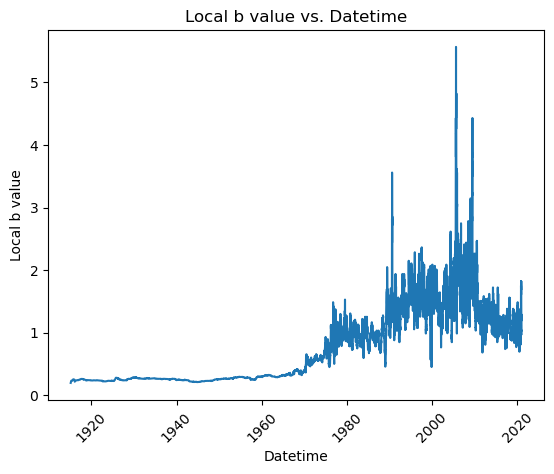

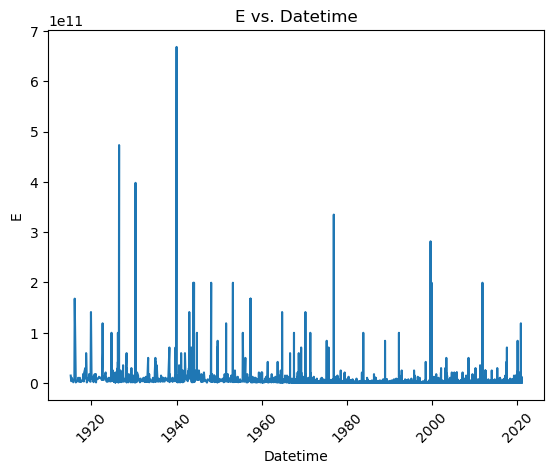

In [10]:
# Plot the 'local b value' against the datetime
plt.plot(data['datetime'], data['local_b_value'])
plt.xlabel('Datetime')
plt.ylabel('Local b value')
plt.title('Local b value vs. Datetime')
plt.xticks(rotation=45)
plt.show()

# Plot the 'local b value' against the datetime
plt.plot(data['datetime'], data['E'])
plt.xlabel('Datetime')
plt.ylabel('E')
plt.title('E vs. Datetime')
plt.xticks(rotation=45)
plt.show()


Beginning of the first Machine Learning Algorithm

In [5]:
#import relevant Modules for ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, balanced_accuracy_score, f1_score

Assigning and prepping variables for training

In [6]:
#Define time period
data = data[(data['datetime'] >= '1978-01-01')] # & (data['datetime'] <= '2005-01-01')]
# Define predictors
X = [
    #'date_num', 
    #'depth', 
    # 'latitude', 
    # 'longitude', 
     'magnitude', 
     'x6', 
     'x7', 
     'meanM', 
     'E', 
     'local_b_value', 
     'TimeElapsed',
     #'T',
     #'dE/dt'
     ]
y = data[['NextWeekHighMagnitude']]

# Split the dataset into training and test sets 
# Define the size of the training, validation, and testing sets
train_size = int(0.8 * len(data))  # 80% of the data for training
val_size = int(0.1 * len(data))  # 10% of the data for validation
test_size = len(data) - train_size - val_size  # Remaining data for testing

# # Split the data linearlly into training, validation, and testing sets
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

# # Separate the predictors (X) and the target variable (y) for each set
X_train = train_data[X]
y_train = train_data[['NextWeekHighMagnitude']]
y_train = y_train.values.ravel()

X_val = val_data[X]
y_val = val_data[['NextWeekHighMagnitude']]
y_val = y_val.values.ravel()

X_test = test_data[X]
y_test = test_data[['NextWeekHighMagnitude']]
y_test = y_test.values.ravel()

#Normalize dataset
scaler  = StandardScaler()
scaler.fit(X_train)

# #applying the transform on our datasets
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


Using GradientBoosting Classifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=  22.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=  24.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=  21.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=  31.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=  28.4s
Best hyperparameters:
 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}

Best model:
 GradientBoostingClassifier(max_depth=None, min_samples_split=4,
                           n_estimators=200)
Training Precision: 1.0
Validation Precision: 0.0
Test Precision: 0.31999999999999995
Training Recall: 1.0
Validation Recall: 0.0
Recall Score: 0.25196850393700787


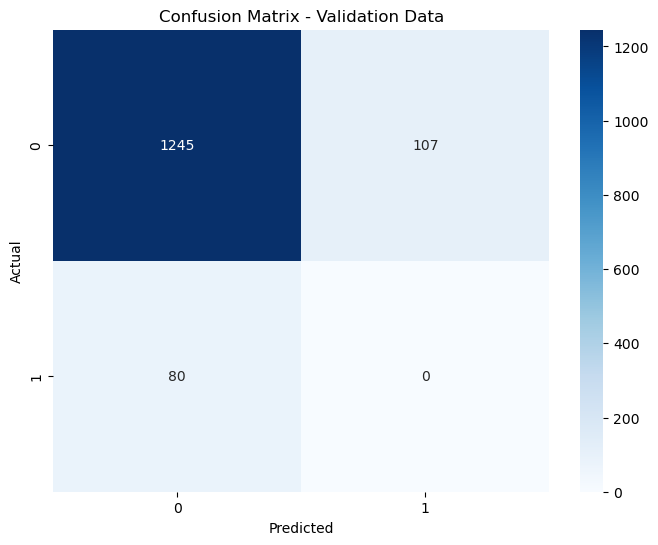

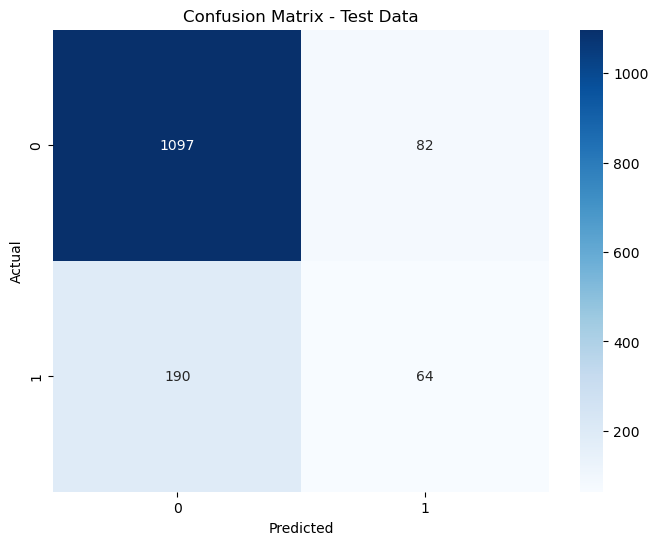

In [39]:
# Define the parameter grid to search
param_grid = {
     'n_estimators': [200],
     'max_depth': [None],
     'min_samples_split': [4],
     'min_samples_leaf': [1]
 }

# Initialize the Random Forest Regressor
rfc = GradientBoostingClassifier()

#Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring= 'recall', verbose=2)

#Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Extract best hyperparameters from 'grid_search'
best_rfc_params = grid_search.best_params_
print("Best hyperparameters:\n", best_rfc_params)

# Extract best model from 'grid_search'
best_rfc_model = grid_search.best_estimator_
print("\nBest model:\n", best_rfc_model)

y_val_pred = best_rfc_model.predict(X_val)
y_test_pred = best_rfc_model.predict(X_test)



print('Training F1-score:', f1_score(y_train, best_rfc_model.predict(X_train)))
print("Validation F1-score:", f1_score(y_val, y_val_pred))
print("Test F1-score:", f1_score(y_test, y_test_pred))
print('Training Recall:', recall_score(y_train, best_rfc_model.predict(X_train)))
print("Validation Recall:", recall_score(y_val, y_val_pred))
print('Recall Score:', recall_score(y_test, y_test_pred))

# Calculate the confusion matrix
cmv = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmv, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Data')
plt.show()




Trying Deep Learning Algorithms

In [7]:
#Import relevant modules for Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, recall_score, f1_score

2023-12-10 23:10:16.645731: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 23:10:16.648101: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 23:10:16.688373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 23:10:16.688421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 23:10:16.690215: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Epoch 1/50
180/180 [==============================] - 5s 13ms/step - loss: 0.8953 - accuracy: 0.4985 - val_loss: 0.6814 - val_accuracy: 0.6068
Epoch 2/50
180/180 [==============================] - 2s 11ms/step - loss: 0.7964 - accuracy: 0.5321 - val_loss: 0.6117 - val_accuracy: 0.8722
Epoch 3/50
180/180 [==============================] - 2s 12ms/step - loss: 0.7303 - accuracy: 0.5604 - val_loss: 0.6312 - val_accuracy: 0.7947
Epoch 4/50
180/180 [==============================] - 2s 11ms/step - loss: 0.7118 - accuracy: 0.5845 - val_loss: 0.6349 - val_accuracy: 0.7654
Epoch 5/50
180/180 [==============================] - 2s 9ms/step - loss: 0.7012 - accuracy: 0.5918 - val_loss: 0.6204 - val_accuracy: 0.7905
Epoch 6/50
180/180 [==============================] - 2s 11ms/step - loss: 0.6740 - accuracy: 0.6090 - val_loss: 0.6183 - val_accuracy: 0.7940
Epoch 7/50
180/180 [==============================] - 2s 13ms/step - loss: 0.6816 - accuracy: 0.6316 - val_loss: 0.6079 - val_accuracy: 0.7961


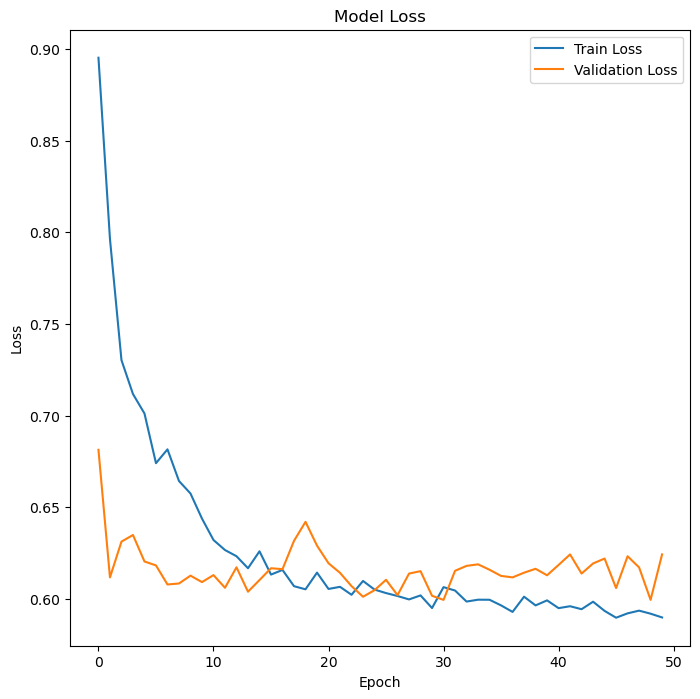

45/45 [==============================] - 0s 3ms/step - loss: 0.7744 - accuracy: 0.6127
Test Loss: 0.7743574976921082
Test Accuracy: 0.6127006411552429
359/359 [==============================] - 1s 4ms/step
F1 score (test): 0.4114528101802758
Training recall score: 0.5724233983286908
Validation recall score: 0.7625
Test recall score: 0.7637795275590551
Training f1 score: 0.28601252609603345
Validation f1 score: 0.24302788844621512
Test f1 score: 0.4114528101802758


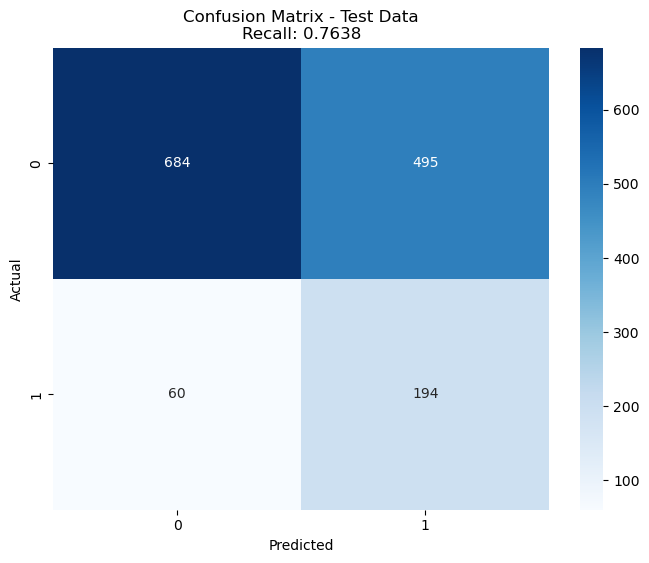

In [43]:
# Define the ANN model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(len(X_train[0]),)))
model.add(BatchNormalization())  # Adding Batch Normalization
model.add(Dropout(0.5))  # Adding Dropout to reduce overfitting
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, class_weight=class_weights_dict, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks=[early_stopping])

# Plot the loss and binary crossentropy curves in the same plot
plt.figure(figsize=(8, 8))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')

plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test set
y_test_pred_probs = model.predict(X_test)
# Get the predicted classes
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Calculate recall
recall = recall_score(y_test, y_test_pred)
#Calculate the precision score
precision = precision_score(y_test, y_test_pred)
# Calculate F1 score
f1 = f1_score(y_test, y_test_pred)

#Calculate predicted values for the Testing and Training set
y_val_pred = ((model.predict(X_val) > 0.5).astype(int))

y_train_pred = ((model.predict(X_train) > 0.5).astype(int))

#Print all scores
print('F1 score (test):', f1)
print('Training recall score:', recall_score(y_train, y_train_pred))
print('Validation recall score:', recall_score(y_val, y_val_pred))
print('Test recall score:', recall)
print('Training f1 score:', f1_score(y_train, y_train_pred))
print('Validation f1 score:', f1_score(y_val, y_val_pred))
print('Test f1 score:', f1)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Test Data\nRecall: {recall:.4f}')
plt.show()


Testing 1D-CNN 

Epoch 1/80
90/90 [==============================] - 2s 10ms/step - loss: 1.0945 - accuracy: 0.4495 - val_loss: 1.0971 - val_accuracy: 0.0566
Epoch 2/80
90/90 [==============================] - 1s 7ms/step - loss: 1.0103 - accuracy: 0.4848 - val_loss: 1.2497 - val_accuracy: 0.0573
Epoch 3/80
90/90 [==============================] - 1s 8ms/step - loss: 0.9578 - accuracy: 0.4985 - val_loss: 1.2366 - val_accuracy: 0.0587
Epoch 4/80
90/90 [==============================] - 1s 7ms/step - loss: 0.9079 - accuracy: 0.5169 - val_loss: 1.1072 - val_accuracy: 0.0733
Epoch 5/80
90/90 [==============================] - 1s 8ms/step - loss: 0.8728 - accuracy: 0.5392 - val_loss: 0.9638 - val_accuracy: 0.2277
Epoch 6/80
90/90 [==============================] - 1s 7ms/step - loss: 0.8707 - accuracy: 0.5515 - val_loss: 0.8781 - val_accuracy: 0.4022
Epoch 7/80
90/90 [==============================] - 1s 7ms/step - loss: 0.8584 - accuracy: 0.5510 - val_loss: 0.8363 - val_accuracy: 0.4846
Epoch 8/80
90/90 [=

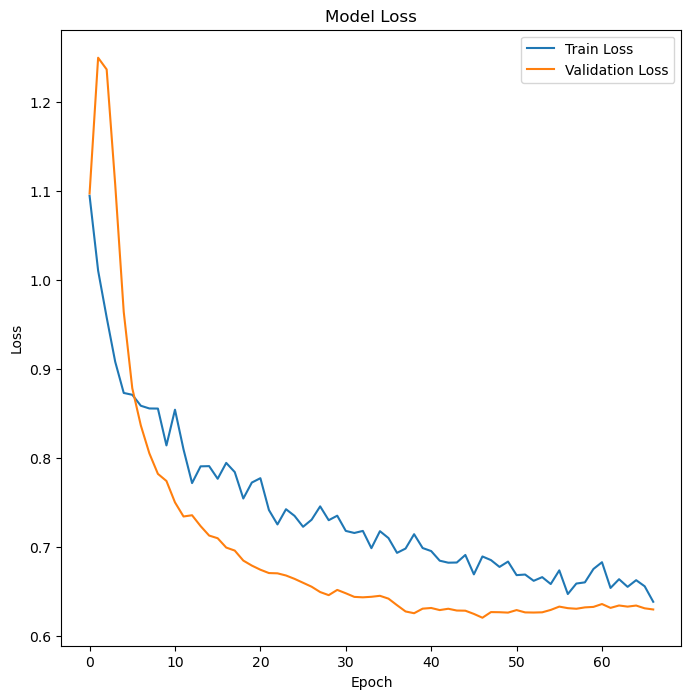

45/45 [==============================] - 0s 3ms/step - loss: 0.7461 - accuracy: 0.6246
Test Loss: 0.7460923790931702
Test Accuracy: 0.6245638728141785
359/359 [==============================] - 1s 3ms/step
F1 score (test): 0.4227467811158798
Training recall score: 0.5459610027855153
Validation recall score: 0.775
Test recall score: 0.7755905511811023
Training f1 score: 0.28160919540229884
Validation f1 score: 0.2505050505050505
Test f1 score: 0.4227467811158798


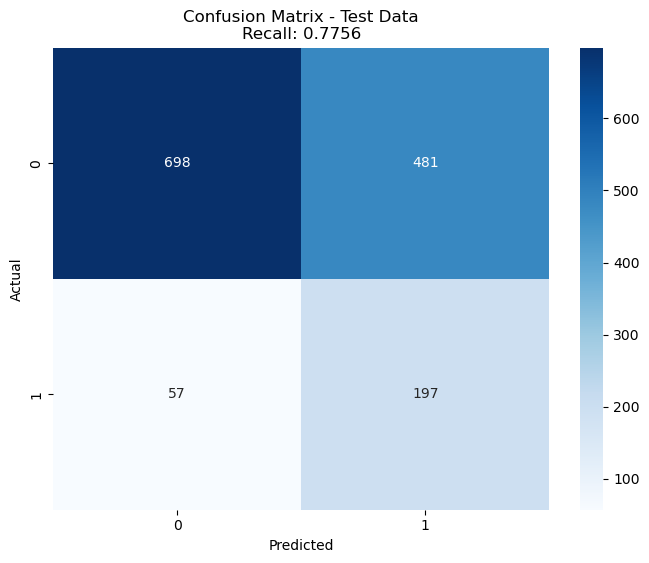

In [33]:
# Reshape input data for 1D CNN
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the 1D CNN model
model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train_cnn.shape[1], 1), padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv1D(64, kernel_size=5, activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_cnn, y_train, class_weight=class_weights_dict, 
                    validation_data=(X_val_cnn, y_val), epochs=80, batch_size=128,
                    callbacks=[early_stopping])


# Plot the loss and binary crossentropy curves in the same plot
plt.figure(figsize=(8, 8))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')

plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_cnn, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test set
y_test_pred_probs = model.predict(X_test_cnn)

# Get the predicted classes
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Calculate recall
recall = recall_score(y_test, y_test_pred)
#Calculate the precision score
precision = precision_score(y_test, y_test_pred)
# Calculate F1 score
f1 = f1_score(y_test, y_test_pred)

#Calculate predicted values for the Testing and Training set
y_val_pred = ((model.predict(X_val_cnn) > 0.5).astype(int))

y_train_pred = ((model.predict(X_train_cnn) > 0.5).astype(int))

#Print all scores
print('F1 score (test):', f1)
print('Training recall score:', recall_score(y_train, y_train_pred))
print('Validation recall score:', recall_score(y_val, y_val_pred))
print('Test recall score:', recall)
print('Training f1 score:', f1_score(y_train, y_train_pred))
print('Validation f1 score:', f1_score(y_val, y_val_pred))
print('Test f1 score:', f1)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Test Data\nRecall: {recall:.4f}')
plt.show()

Trying an LSTM -(NOT USED IN THE END)

Epoch 1/60
180/180 [==============================] - 6s 17ms/step - loss: 0.8389 - accuracy: 0.5504 - val_loss: 0.6440 - val_accuracy: 0.9441
Epoch 2/60
180/180 [==============================] - 3s 14ms/step - loss: 0.8291 - accuracy: 0.5634 - val_loss: 0.5787 - val_accuracy: 0.9378
Epoch 3/60
180/180 [==============================] - 2s 13ms/step - loss: 0.8041 - accuracy: 0.5734 - val_loss: 0.5632 - val_accuracy: 0.8513
Epoch 4/60
180/180 [==============================] - 2s 13ms/step - loss: 0.8039 - accuracy: 0.5721 - val_loss: 0.6316 - val_accuracy: 0.7339
Epoch 5/60
180/180 [==============================] - 3s 15ms/step - loss: 0.7738 - accuracy: 0.5720 - val_loss: 0.6603 - val_accuracy: 0.6906
Epoch 6/60
180/180 [==============================] - 2s 14ms/step - loss: 0.7872 - accuracy: 0.5786 - val_loss: 0.6562 - val_accuracy: 0.7025
Epoch 7/60
180/180 [==============================] - 3s 14ms/step - loss: 0.7688 - accuracy: 0.5972 - val_loss: 0.6669 - val_accuracy: 0.6795

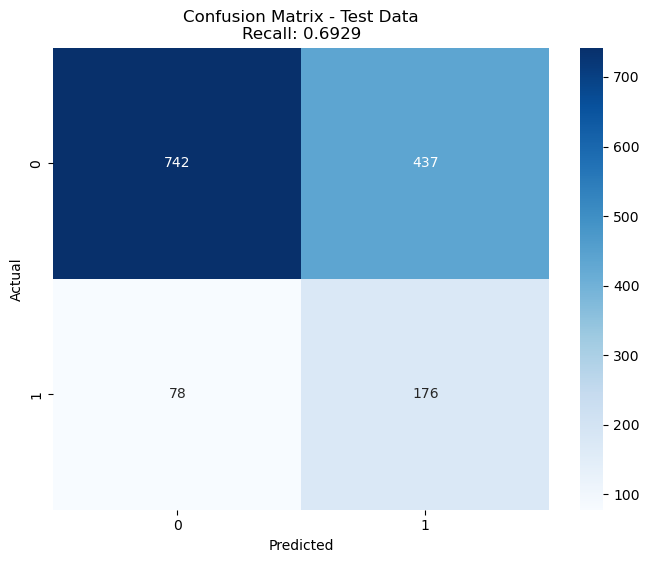

In [35]:

# Reshape input data for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_lstm = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train_lstm.shape[1], 1), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_lstm, y_train, class_weight=class_weights_dict, 
                    validation_data=(X_val_lstm, y_val), epochs=60, batch_size=64,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_lstm, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test set
y_test_pred_probs = model.predict(X_test_lstm)

# Get the predicted classes
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Calculate recall
recall = recall_score(y_test, y_test_pred)
#Calculate the precision score
precision = precision_score(y_test, y_test_pred)
# Calculate F1 score
f1 = f1_score(y_test, y_test_pred)

#Calculate predicted values for the Testing and Training set
y_val_pred = ((model.predict(X_val_lstm) > 0.5).astype(int))

y_train_pred = ((model.predict(X_train_lstm) > 0.5).astype(int))

#Print all scores
print('F1 score (test):', f1)
print('Training recall score:', recall_score(y_train, y_train_pred))
print('Validation recall score:', recall_score(y_val, y_val_pred))
print('Test recall score:', recall)
print('Training f1 score:', f1_score(y_train, y_train_pred))
print('Validation f1 score:', f1_score(y_val, y_val_pred))
print('Test f1 score:', f1)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Test Data\nRecall: {recall:.4f}')
plt.show()

